In [3]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score
from IPython.display import clear_output

In [4]:
print("Train Nodule: ", len(os.listdir("/kaggle/input/fpr-candidates-dataset/FPRDataset/train/nodule")))
print("Train Non-Nodule: ", len(os.listdir("/kaggle/input/fpr-candidates-dataset/FPRDataset/train/non-nodule")))
print("Test Nodule: ", len(os.listdir("/kaggle/input/fpr-candidates-dataset/FPRDataset/test/nodule")))
print("Test Non-Nodule: ", len(os.listdir("/kaggle/input/fpr-candidates-dataset/FPRDataset/test/non-nodule")))

Train Nodule:  506
Train Non-Nodule:  39301
Test Nodule:  169
Test Non-Nodule:  13101


In [5]:
# Data Generator with Augmentation
generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [6]:
# Train/Test Data
trainData = generator.flow_from_directory(
    "/kaggle/input/fpr-candidates-dataset/FPRDataset/train",
    target_size=(50, 50),
    batch_size=64,  # Reduced batch size
    color_mode='grayscale',
    class_mode='binary'
)
testData = generator.flow_from_directory(
    "/kaggle/input/fpr-candidates-dataset/FPRDataset/test",
    target_size=(50, 50),
    batch_size=64,
    color_mode='grayscale',
    class_mode='binary'
)

print(trainData.class_indices)
print(testData.class_indices)

Found 39807 images belonging to 2 classes.
Found 13270 images belonging to 2 classes.
{'nodule': 0, 'non-nodule': 1}
{'nodule': 0, 'non-nodule': 1}


In [7]:
# Define Dense Block
def dense_block(x, growth_rate, filters):
    for _ in range(4):  # Number of layers in the dense block
        out = tf.keras.layers.BatchNormalization()(x)
        out = tf.keras.layers.ReLU()(out)
        out = tf.keras.layers.Conv2D(
            growth_rate, (3, 3), padding="same", kernel_initializer="he_normal"
        )(out)
        out = tf.keras.layers.Dropout(0.3)(out)  # Dropout regularization
        filters += growth_rate
        x = tf.keras.layers.concatenate([x, out])
    return x, filters

In [8]:
# Define Transition Layer
def transition_layer(x, filters):
    out = tf.keras.layers.BatchNormalization()(x)
    out = tf.keras.layers.ReLU()(out)
    out = tf.keras.layers.Conv2D(filters, (1, 1), use_bias=False)(out)
    out = tf.keras.layers.AveragePooling2D((2, 2), strides=2)(out)
    return out

In [9]:
# Build Model
def build_model(input_shape=(50, 50, 1), num_classes=1):
    inputs = tf.keras.Input(shape=input_shape)

    # Initial convolution
    x = tf.keras.layers.Conv2D(
        64, (7, 7), strides=2, padding="same", kernel_initializer="he_normal"
    )(inputs)

    # Dense blocks and transition layers
    filters = 64
    x, filters = dense_block(x, 48, filters)  # Increased growth rate
    x = transition_layer(x, filters // 2)

    x, filters = dense_block(x, 48, filters)
    x = transition_layer(x, filters // 2)

    # Global average pooling and output layer
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [10]:
# Compile Model
model = build_model()
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50, 50, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 25, 25,    │      3,200 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 25, 25,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 25, 25,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 25, 25,    │     27,696 │ re_lu[0][0]       │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 25, 25,    │          0 │ conv2d_1[0][0]    │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 25, 25,    │          0 │ conv2d[0][0],     │
│ (Concatenate)       │ 112)              │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 25,    │        448 │ concatenate[0][0] │
│ (BatchNormalizatio… │ 112)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 25, 25,    │          0 │ batch_normalizat… │
│                     │ 112)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 25, 25,    │     48,432 │ re_lu_1[0][0]     │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 25, 25,    │          0 │ conv2d_2[0][0]    │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 25, 25,    │          0 │ concatenate[0][0… │
│ (Concatenate)       │ 160)              │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 25,    │        640 │ concatenate_1[0]… │
│ (BatchNormalizatio… │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 25, 25,    │          0 │ batch_normalizat… │
│                     │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 25, 25,    │     69,168 │ re_lu_2[0][0]     │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 25, 25,    │          0 │ conv2d_3[0][0]    │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 25, 25,    │          0 │ concatenate_1[0]

 Total params: 696,545 (2.66 MB)

 Trainable params: 692,705 (2.64 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [11]:
# Custom Callback for Metrics Monitoring
class MetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_pred = (self.model.predict(testData) > 0.5).astype(int).flatten()
        val_true = testData.classes
        precision = precision_score(val_true, val_pred, zero_division=1)
        recall = recall_score(val_true, val_pred, zero_division=1)
        f1 = f1_score(val_true, val_pred, zero_division=1)
        print(f"Epoch {epoch+1}: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")

In [12]:
# Callbacks
weight_path = "checkpoint-{epoch:03d}-{val_loss:.3f}.weights.h5"
modelcheckpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
metrics_callback = MetricsCallback()

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dense, Flatten, Dropout, Concatenate
from tensorflow.keras.layers import AveragePooling2D

In [14]:
# Train Model
with tf.device("/device:GPU:0"):  # Ensure GPU is used
    history = model.fit(
        trainData,
        epochs=50,
        validation_data=testData,
        callbacks=[modelcheckpoint, early_stop, metrics_callback],
        verbose=1
    )

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732341343.544879      90 service.cc:145] XLA service 0x7d0724007d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732341343.544936      90 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732341343.544940      90 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/622 ━━━━━━━━━━━━━━━━━━━━ 38s 62ms/step - accuracy: 0.9844 - loss: 0.2193   

I0000 00:00:1732341365.284620      90 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


621/622 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.9870 - loss: 0.0808
Epoch 1: val_loss improved from inf to 0.06916, saving model to checkpoint-001-0.069.weights.h5
208/208 ━━━━━━━━━━━━━━━━━━━━ 37s 175ms/step
Epoch 1: Precision=0.9873, Recall=1.0000, F1=0.9936
622/622 ━━━━━━━━━━━━━━━━━━━━ 341s 497ms/step - accuracy: 0.9870 - loss: 0.0808 - val_accuracy: 0.9873 - val_loss: 0.0692
Epoch 2/50
621/622 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9865 - loss: 0.0734
Epoch 2: val_loss did not improve from 0.06916
208/208 ━━━━━━━━━━━━━━━━━━━━ 18s 86ms/step
Epoch 2: Precision=0.9873, Recall=1.0000, F1=0.9936
622/622 ━━━━━━━━━━━━━━━━━━━━ 124s 197ms/step - accuracy: 0.9865 - loss: 0.0734 - val_accuracy: 0.9873 - val_loss: 0.0726
Epoch 3/50
621/622 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9873 - loss: 0.0678
Epoch 3: val_loss did not improve from 0.06916
208/208 ━━━━━━━━━━━━━━━━━━━━ 18s 86ms/step
Epoch 3: Precision=0.9873, Recall=1.0000, F1=0.9936
622/622 ━━━━━━━━━━━━━━━━━━━━ 9

Final Accuracy: 0.9905292987823486


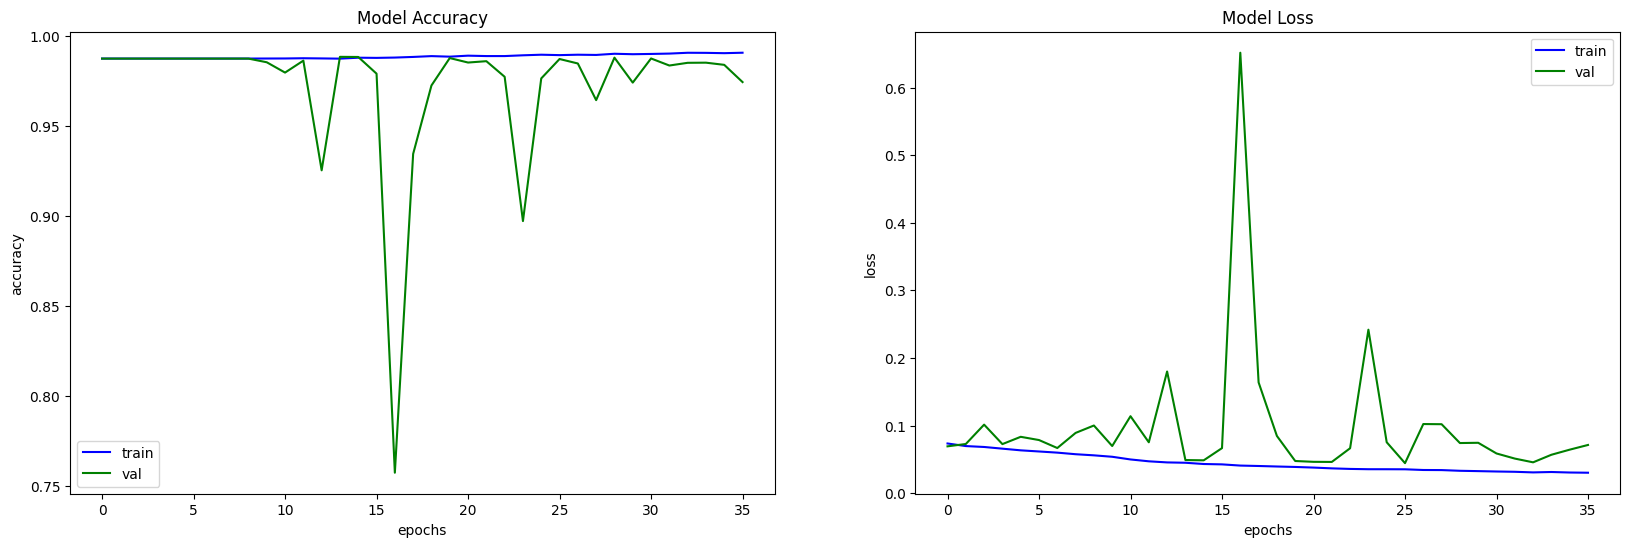

In [15]:
plt.figure(figsize=(20,6))
for i, met in enumerate(['accuracy', 'loss']):
  plt.subplot(1,2,i+1)
  plt.plot(history.history[met], color="b")
  plt.plot(history.history["val_"+met], color="g")
  plt.title('Model '+met.capitalize())
  plt.xlabel('epochs')
  plt.ylabel(met)
  plt.legend(['train', 'val'])

final_accuracy = history.history['accuracy'][-1]
print("Final Accuracy:", final_accuracy)
plt.show()

In [16]:
model.save("/kaggle/working/DenseNet_Model.h5")